In [39]:
from tqdm import tqdm
import wandb
api = wandb.Api(timeout=180)
import os
import pandas as pd
import wandb
import yaml
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import itertools
import  matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import time
import matplotlib as mpl

In [40]:
USER='wilderlavington' 
PROJECT='FunctionalOptimization'
SUMMARY_FILE='aistats_fig1.csv' 
K=1
try:
    os.makedirs("plots/aistats/")
except FileExistsError:
    print("File already exists")

File already exists


In [41]:
def download_wandb_summary(label = 'workshop-fig1'):
    """
    Download a summary of all runs on the wandb project
    """
    runs = api.runs(USER+'/'+PROJECT, per_page=1000000000)
    summary_list, config_list, name_list, id_list, commits = [], [], [], [], []
    assert len([run for run in runs]) 
    for run in tqdm(runs):
        run = api.run(USER+'/'+PROJECT+"/"+run.id)
        conf = {k: v for k, v in run.config.items()}
        if 'label' in conf.keys(): 
            if conf['label'] == label:
                summary_list.append(run.summary._json_dict)
                config_list.append(conf)
                name_list.append(run.name)
                id_list.append(run.id)
                commits.append(run.commit)
        else:
            pass
    assert len(summary_list)
    commits_df = pd.DataFrame.from_records(commits)
    summary_df = pd.DataFrame.from_records(summary_list)
    config_df = pd.DataFrame.from_records(config_list)
    name_df = pd.DataFrame({"name": name_list, "id": id_list})
    all_df = pd.concat([name_df, config_df, summary_df, commits_df], axis=1)
    Path('logs/wandb_data/').mkdir(parents=True, exist_ok=True)
    all_df.to_csv('logs/wandb_data/'+SUMMARY_FILE)

In [42]:
download_wandb_summary()

100%|███████████████████████████████████████| 7325/7325 [29:09<00:00,  4.19it/s]


In [43]:
def download_wandb_records():
    """
    Download data for all runs in summary file
    """
    # load it all in and clean it up
    runs_df = pd.read_csv('logs/wandb_data/'+SUMMARY_FILE, header=0, squeeze=True)
    runs_df = runs_df.loc[:,~runs_df.columns.duplicated()]
    columns_of_interest = ['avg_loss', 'optim_steps', 'grad_norm', 'time_elapsed', \
             'grad_evals', 'function_evals', 'eta', 'inner_steps', 'eta_scale']
    # set which columns we will store for vizualization
    list_of_dataframes = []
    # iterate through all runs to create individual databases
    for ex in tqdm(range(len(runs_df)), leave=False):
        # get the associated runs
        try:
            run = api.run(USER+'/'+PROJECT+'/'+runs_df.loc[runs_df.iloc[ex,0],:]['id'])
            run_df = []
            # iterate through all rows in online database
            base_info = {}
            for key in runs_df.loc[runs_df.iloc[ex,0],:].keys():
                base_info.update({key:runs_df.loc[runs_df.iloc[ex,0],:][key]})
            for i, row in run.history().iterrows():
                row_info = deepcopy(base_info)
                row_info.update({key:row[key] for key in columns_of_interest if key in row.keys()})
                run_df.append(row_info)
            # convert format to dataframe and add to our list
            list_of_dataframes.append(pd.DataFrame(run_df))
        except:
            pass
    # combine and then store
    wandb_records = pd.concat(list_of_dataframes)
    wandb_records.to_csv('logs/wandb_data/__full__'+SUMMARY_FILE)
    # return single data frame for vizualization
    return wandb_records

In [44]:
download_wandb_records()

Unnamed: 0                  name        id    c   m        algo     loss  \
0             0  firm-armadillo-14609  nt9dgvjh  0.1  20  SGD_FMDOpt  MSELoss   
1             0  firm-armadillo-14609  nt9dgvjh  0.1  20  SGD_FMDOpt  MSELoss   
2             0  firm-armadillo-14609  nt9dgvjh  0.1  20  SGD_FMDOpt  MSELoss   
3             0  firm-armadillo-14609  nt9dgvjh  0.1  20  SGD_FMDOpt  MSELoss   
4             0  firm-armadillo-14609  nt9dgvjh  0.1  20  SGD_FMDOpt  MSELoss   
..          ...                   ...       ...  ...  ..         ...      ...   
495         561    vibrant-haze-13986  1glrktqs  0.1   1  SGD_FMDOpt  MSELoss   
496         561    vibrant-haze-13986  1glrktqs  0.1   1  SGD_FMDOpt  MSELoss   
497         561    vibrant-haze-13986  1glrktqs  0.1   1  SGD_FMDOpt  MSELoss   
498         561    vibrant-haze-13986  1glrktqs  0.1   1  SGD_FMDOpt  MSELoss   
499         561    vibrant-haze-13986  1glrktqs  0.1   1  SGD_FMDOpt  MSELoss   

     seed           group          label           entity  log_lr  outer_c  \
0       2  AIstats_narval  workshop-fig1  wilderlavington    -4.0      0.5   
1       2  AIstats_narval  workshop-fig1  wilderlavington    -4.0      0.5   
2       2  AIstats_narval  workshop-fig1  wilderlavington    -4.0      0.5   
3       2  AIstats_narval  workshop-fig1  wilderlavington    -4.0      0.5   
4       2  AIstats_narval  workshop-fig1  wilderlavington    -4.0      0.5   
..    ...             ...            ...              ...     ...      ...   
495     1  AIstats_narval  workshop-fig1  wilderlavington    -4.0      0.5   
496     1  AIstats_narval  workshop-fig1  wilderlavington    -4.0      0.5   
497     1  AIstats_narval  workshop-fig1  wilderlavington    -4.0      0.5   
498     1  AIstats_narval  workshop-fig1  wilderlavington    -4.0      0.5   
499     1  AIstats_narval  workshop-fig1  wilderlavington    -4.0      0.5   

                    project  episodes file_name  fullbatch inner_opt  \
0    FunctionalOptimization       100   example          0     LSOpt   
1    FunctionalOptimization       100   example          0     LSOpt   
2    FunctionalOptimization       100   example          0     LSOpt   
3    FunctionalOptimization       100   example          0     LSOpt   
4    FunctionalOptimization       100   example          0     LSOpt   
..                      ...       ...       ...        ...       ...   
495  FunctionalOptimization       100   example          0     LSOpt   
496  FunctionalOptimization       100   example          0     LSOpt   
497  FunctionalOptimization       100   example          0     LSOpt   
498  FunctionalOptimization       100   example          0     LSOpt   
499  FunctionalOptimization       100   example          0     LSOpt   

     batch_size  min_epochs  beta_update folder_name  matfac_xdim  \
0             5         500          0.9   examples/            6   
1             5         500          0.9   examples/            6   
2             5         500          0.9   examples/            6   
3             5         500          0.9   examples/            6   
4             5         500          0.9   examples/            6   
..          ...         ...          ...         ...          ...   
495           5         500          0.9   examples/            6   
496           5         500          0.9   examples/            6   
497           5         500          0.9   examples/            6   
498           5         500          0.9   examples/            6   
499           5         500          0.9   examples/            6   

     matfac_ydim dataset_name eta_schedule  expand_coeff  min_episodes  \
0             10    mushrooms     constant             2             1   
1             10    mushrooms     constant             2             1   
2             10    mushrooms     constant             2             1   
3             10    mushrooms     constant             2             1   
4             10    mushrooms  

In [45]:
def smooth(array, k):
    array = np.array(array)
    new_array = deepcopy(array)
    # print(array[max(0,i-k):i] )
    for i in range(len(array)):
        if str(array[i]) != 'nan':
            avg_list = [val for val in array[max(0,i-k):i+1] if str(val) != 'nan']
            new_array[i] = sum(avg_list) / len(avg_list)
    return new_array
def format_dataframe(records, id_subfields={}, avg_subfields=['seed'],
            max_subfields=['log_lr', 'eta_schedule', 'c'],
            x_col='optim_steps', y_col='avg_loss'):
    #
    pd.set_option('display.max_columns', None)
    max_subfields = [m for m in max_subfields if m not in id_subfields.keys()]
    for key in id_subfields:  
        records = records.loc[records[key] == id_subfields[key]] 
    records['function_evals+grad_evals'] = records['function_evals']+records['grad_evals']
    if not len(records):
        return None
    # remove nans
    records = records[records[y_col].notna()]
    important_cols = list(set(avg_subfields+max_subfields+\
        list(id_subfields.keys())+[x_col, y_col, 'optim_steps']))
    # remove redundant information
    records = records[important_cols]
    # average over avg_subfields
    records = records.drop(avg_subfields, axis=1)
    # group over averaging field
    gb = list(set(list(max_subfields+list(id_subfields.keys())+[x_col, 'optim_steps'])))
    # only look at final optim steps
    last_mean_records = records.loc[records['optim_steps'] == records['optim_steps'].max()]
    # get the best record
    best_record = last_mean_records[last_mean_records[y_col] == last_mean_records[y_col].min()]
    # find parameters of the best record
    merge_on = list(set(gb)-set(['optim_steps', x_col, y_col]))
    merge_on = [ x for x in merge_on if x in best_record.columns.values]
    best_records = pd.merge(best_record[merge_on], records, on=merge_on,how='left')
    final_records = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].mean()
    final_records[y_col+'25'] = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].quantile(0.25)[y_col]
    final_records[y_col+'75'] = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].quantile(0.75)[y_col]
    final_records = final_records.sort_values(x_col, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
    # smooth outputs 
    final_records[y_col+'75'] = smooth(final_records[y_col+'75'],K)
    final_records[y_col+'25'] = smooth(final_records[y_col+'25'],K)
    final_records[y_col] = smooth(final_records[y_col],K) 
    # return 
    return final_records

In [46]:
def generate_plot(proc_df, x, y, ax, label, linestyle='solid', color=None, x_max=5000000):
    low_order_idx = (torch.tensor(proc_df[x].values) < x_max).nonzero().reshape(-1)
    if label:
        ax.plot(torch.tensor(proc_df[x].values[low_order_idx]), 
                torch.tensor(proc_df[y].values[low_order_idx]), 
                label=label, linestyle=linestyle, color=color, alpha=0.8,
                linewidth=4)
    else:
        ax.plot(torch.tensor(proc_df[x].values[low_order_idx]), 
                torch.tensor(proc_df[y].values[low_order_idx]), 
                label='_nolegend_', linestyle=linestyle, color=color, alpha=0.8,
                linewidth=4)
    ax.fill_between(torch.tensor(proc_df[x].values)[low_order_idx],
            torch.tensor(proc_df[y+'75'].values)[low_order_idx],
            torch.tensor(proc_df[y+'25'].values)[low_order_idx], 
            alpha = 0.4, label='_nolegend_', linestyle=linestyle, color=color)
    return ax

In [97]:
def generate_figure_1a(loss, schedule, wandb_records):
    
    # base info   
    dataset_names = ['mushrooms', 'ijcnn', 'rcv1']
    batch_sizes = [25, 125, 625]
    m = [1, 5, 10, 20]
    x = 'optim_steps'
    y = 'avg_loss'
    
    # init plots 
    fig, axs = plt.subplots(len(dataset_names), len(batch_sizes)+1, figsize=(16, 8))
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD':colors[0], 'SLS':colors[1]}
    colormap.update({'FuncOpt'+str(m_):colors[idx+2] for idx, m_ in enumerate(m)})
    algorithms = ['SGD', 'SLS'] + ['FuncOpt'+str(m_) for m_ in m]
#     plt.title('Comparison of SGD, SLS, Functional-SGD: '+loss)
    label_map = {x:'Optimization-Steps', y:'Gradient-Norm'}
    
    # now add in the lines to each of the plots 
    for row, dataset_name in enumerate(dataset_names):
        
        # figure out axis automatically 
        x_max = 0 

        # SLS
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None:
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='SLS', 
                                         linestyle='solid', color=colormap['SLS'])
        else:
            print('missing SLS  ', dataset_name, 'full-batch')

        # SGD
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None: 
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='SGD', 
                                         linestyle='solid', color=colormap['SGD'])
        else:
            print('missing SGD  ', dataset_name, 'full-batch')
        # FMDopt theoretical 
        for m_ in m:
            # create parsed info 
            proc_df = format_dataframe(wandb_records, 
                id_subfields={'fullbatch': 1,   
                    'use_optimal_stepsize': 1, 
                    'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                     avg_subfields=['seed'], max_subfields=['c'],
                x_col=x, y_col=y)
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1],  \
                                        label='FuncOpt'+str(m_), linestyle='solid', color=colormap['FuncOpt'+str(m_)])
            else:
                print('missing FMDopt  ', m_, dataset_name, 'full-batch')
        
#        axs[row][-1].set_xlim(0, x_max) 
        axs[row][-1].grid()    
#         axs[row][-1].set_title('schedule: '+schedule+', batch_size: full-batch', fontsize=18)
        axs[row][-1].set_yscale("log")
        axs[row][-1].set_xscale("log")
#         axs[row][-1].set_xlabel(label_map[x], fontsize=16)
#         axs[row][-1].set_ylabel(label_map[y], fontsize=16)
#        axs[row][-1].tick_params(axis='both', which='major', labelsize=14)
#        axs[row][-1].tick_params(axis='both', which='minor', labelsize=14)
        
        # mini-batch plots 
        for col, batch_size in enumerate(batch_sizes):
            
            # figure out axis automatically 
            x_max = 0 
            
            # SLS
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size,  #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SLS', 
                                             linestyle='solid', color=colormap['SLS'])
            else:
                print('missing SLS  ', dataset_name, batch_size)
            
            # SGD
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, '_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None: 
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SGD', 
                                             linestyle='solid', color=colormap['SGD'])
            else:
                print('missing SGD  ', dataset_name, batch_size)
    
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size,  
                        'use_optimal_stepsize': 1, '_step': 499.0,
                        'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col=x, y_col=y)
                if proc_df is not None:
                    x_max = max(proc_df[x].values.max(), x_max)
                    axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], \
                                            label='FuncOpt'+str(m_), linestyle='solid', color=colormap['FuncOpt'+str(m_)])
                else:
                    print('missing FMDopt  ', m_, dataset_name, batch_size)
            
#             axs[row][col].set_xlim(0, x_max)
            axs[row][col].grid()    
            
#             axs[row][col].set_xlabel(label_map[x], fontsize=16)
#             axs[row][col].set_ylabel(label_map[y], fontsize=16)
#             axs[row][col].tick_params(axis='both', which='major', labelsize=14)
#             axs[row][col].tick_params(axis='both', which='minor', labelsize=14)
            axs[row][col].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
            axs[row][col].set_yscale("log")
            axs[row][col].set_xscale("log")
            axs[0][col].set_title('batch_size: '+str(batch_size), fontsize=22)
            axs[0][-1].set_title('full-batch', fontsize=22)
            axs[row][0].set_ylabel(dataset_name, fontsize=22)
            
#     axs[0][-1].set_title('problem: '+dataset_name, fontsize=22)
    # remaining format stuff  
    handles = [mpatches.Patch(color=colormap[algo], label=algo) for algo in algorithms]
    leg = fig.legend(handles=handles,
           loc="lower center",   # Position of legend
           borderaxespad=1.65,    # Small spacing around legend box
           # title="Algorithms",  # Title for the legend
           fontsize=18,
           ncol=7, 
           bbox_to_anchor=(0.525, -0.12),
           )
    
    plt.subplots_adjust(hspace=1.5)
    plt.rcParams['figure.dpi'] = 400 
#     plt.suptitle('Optimizer Comparison: '+loss, fontsize=28)
    fig.tight_layout()

    # fig.subplots_adjust(top=0.95) 
    # show / save
    plt.savefig('plots/workshop-plot1-'+loss+'.pdf', bbox_inches='tight')
    plt.show() 

In [98]:
wandb_records = pd.read_csv('logs/wandb_data/__full__'+SUMMARY_FILE, header=0, squeeze=True)

/home/wlavington/Desktop/mujoco_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (50,54,55,56,57,58,60,61,63,64,66,69,70,73,77,79,84,85,86,87,88,89,90,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


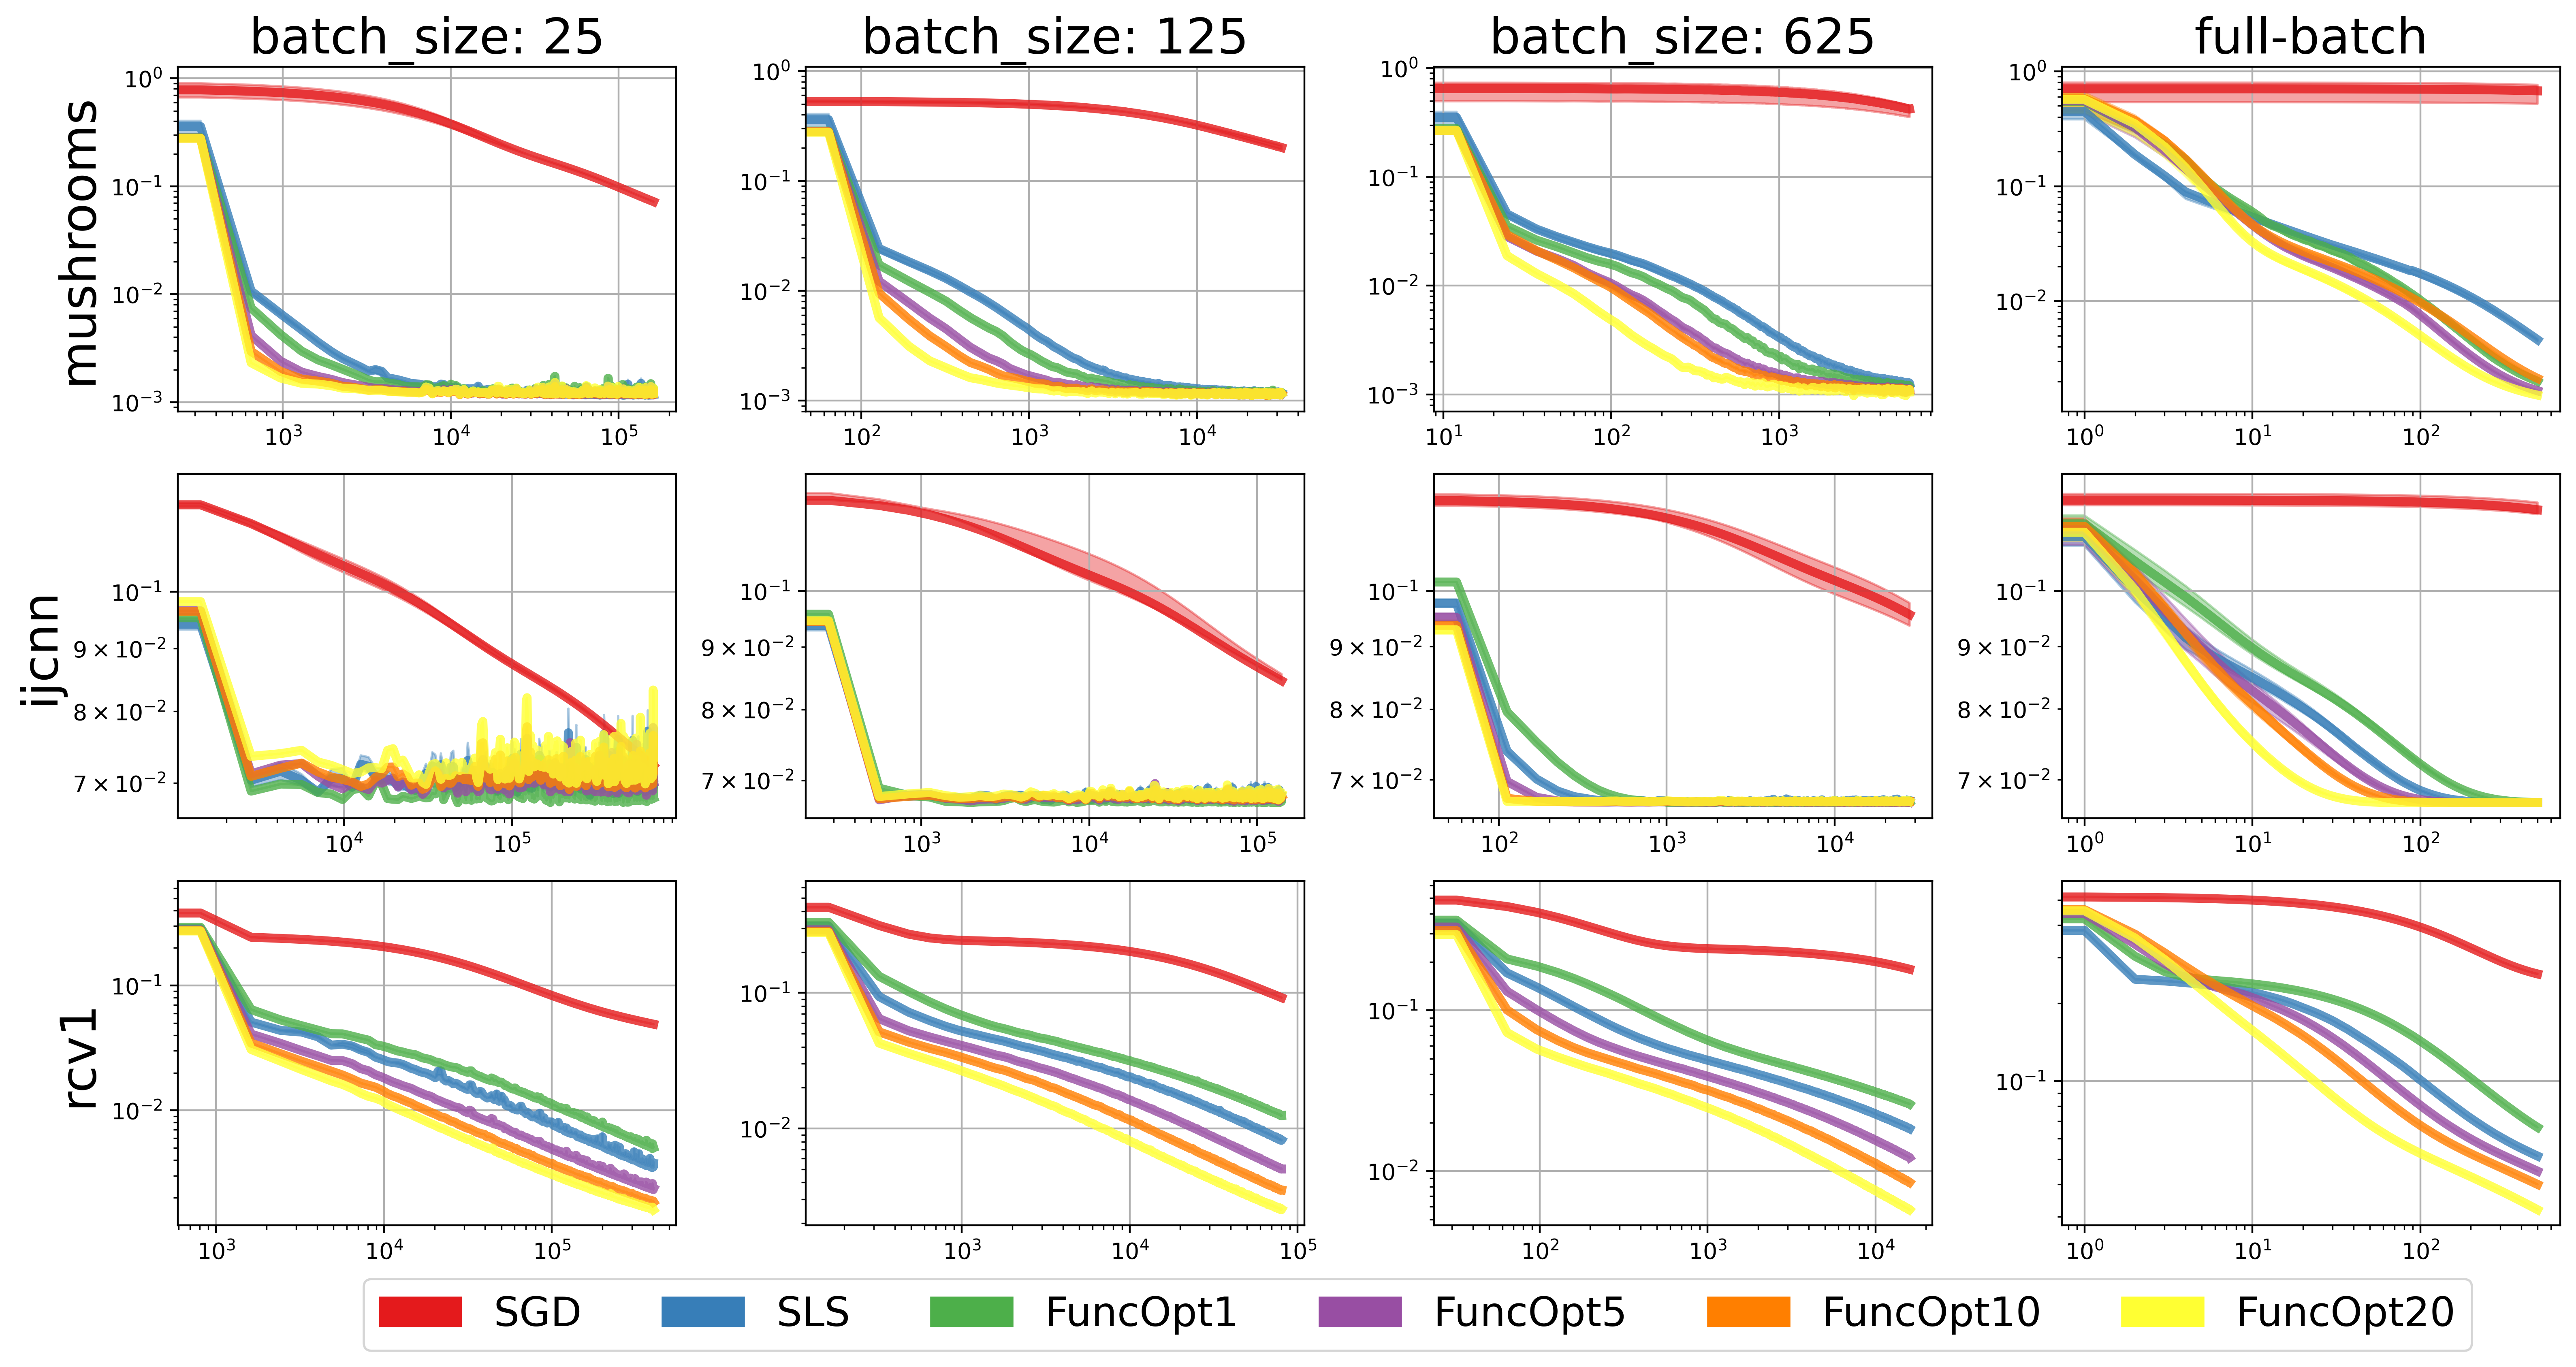

In [99]:
generate_figure_1a('MSELoss', 'constant', wandb_records) 

missing SGD   rcv1 125


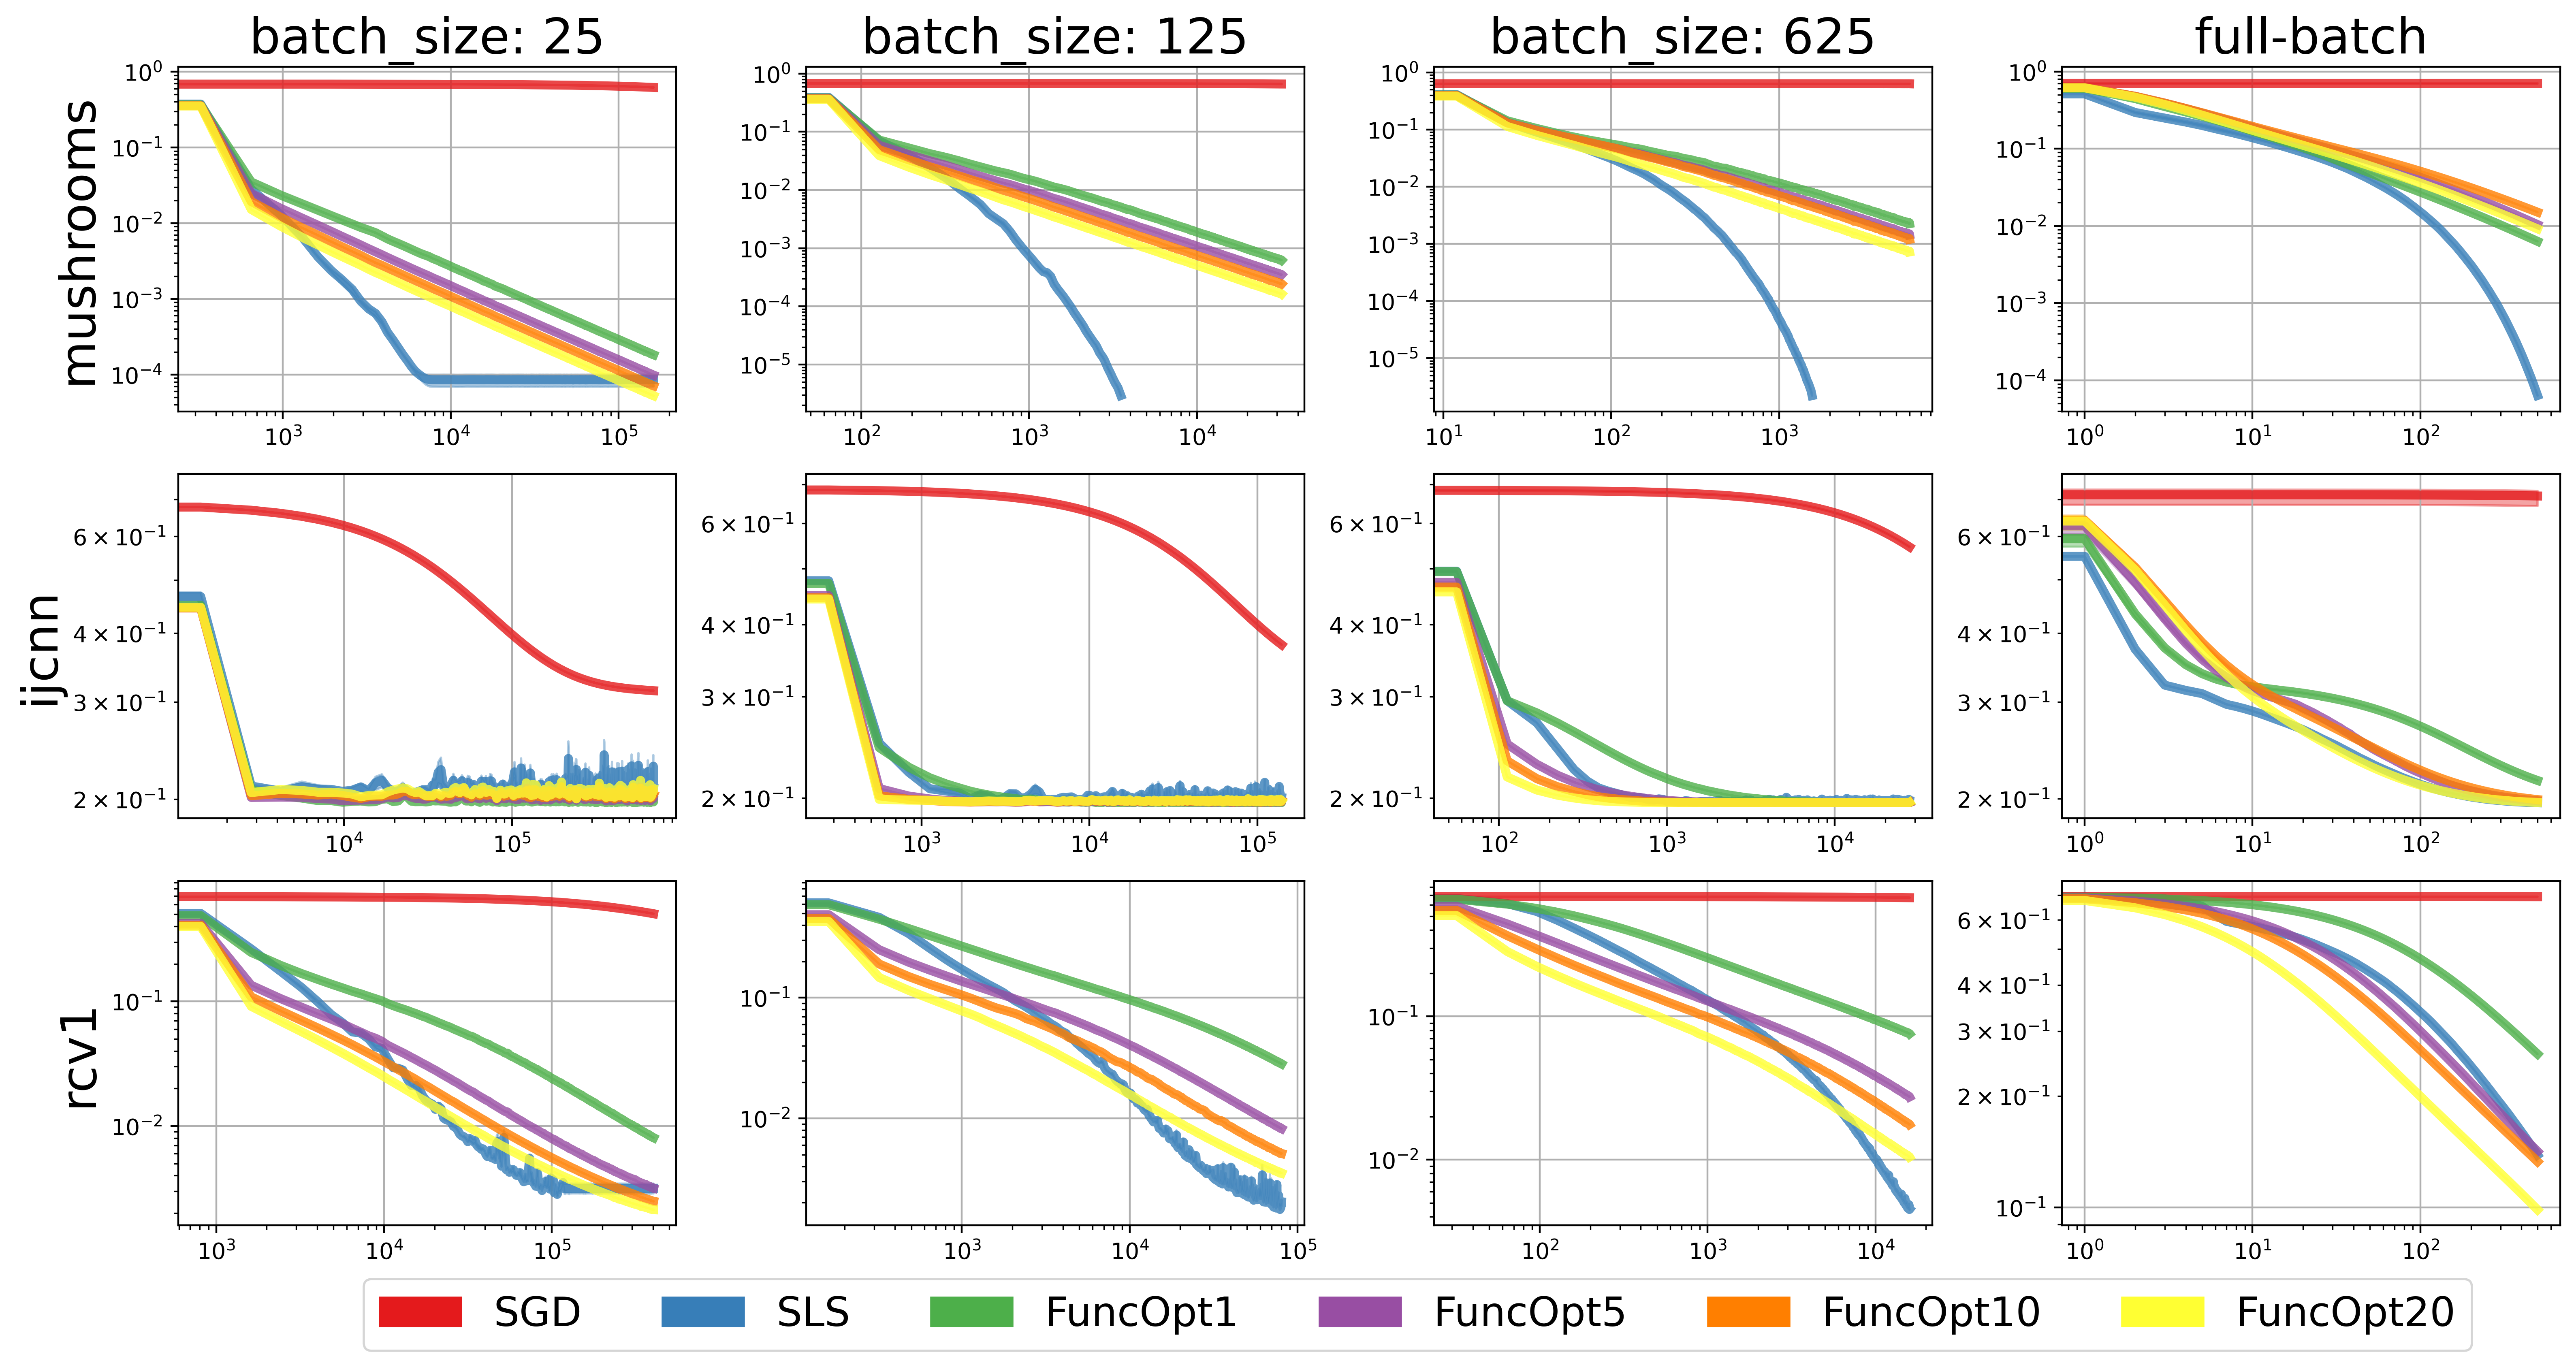

In [100]:
generate_figure_1a('BCEWithLogitsLoss', 'constant', wandb_records) 

missing SLS   mushrooms full-batch
missing SGD   mushrooms full-batch
missing FMDopt   1 mushrooms full-batch
missing FMDopt   5 mushrooms full-batch
missing FMDopt   10 mushrooms full-batch
missing FMDopt   20 mushrooms full-batch
missing SLS   mushrooms 25
missing SGD   mushrooms 25
missing FMDopt   1 mushrooms 25
missing FMDopt   5 mushrooms 25
missing FMDopt   10 mushrooms 25
missing FMDopt   20 mushrooms 25
missing SLS   mushrooms 125
missing SGD   mushrooms 125
missing FMDopt   1 mushrooms 125
missing FMDopt   5 mushrooms 125
missing FMDopt   10 mushrooms 125
missing FMDopt   20 mushrooms 125
missing SLS   mushrooms 625
missing SGD   mushrooms 625
missing FMDopt   1 mushrooms 625
missing FMDopt   5 mushrooms 625
missing FMDopt   10 mushrooms 625
missing FMDopt   20 mushrooms 625
missing SLS   ijcnn full-batch
missing SGD   ijcnn full-batch
missing FMDopt   1 ijcnn full-batch
missing FMDopt   5 ijcnn full-batch
missing FMDopt   10 ijcnn full-batch
missing FMDopt   20 ijcnn full-ba

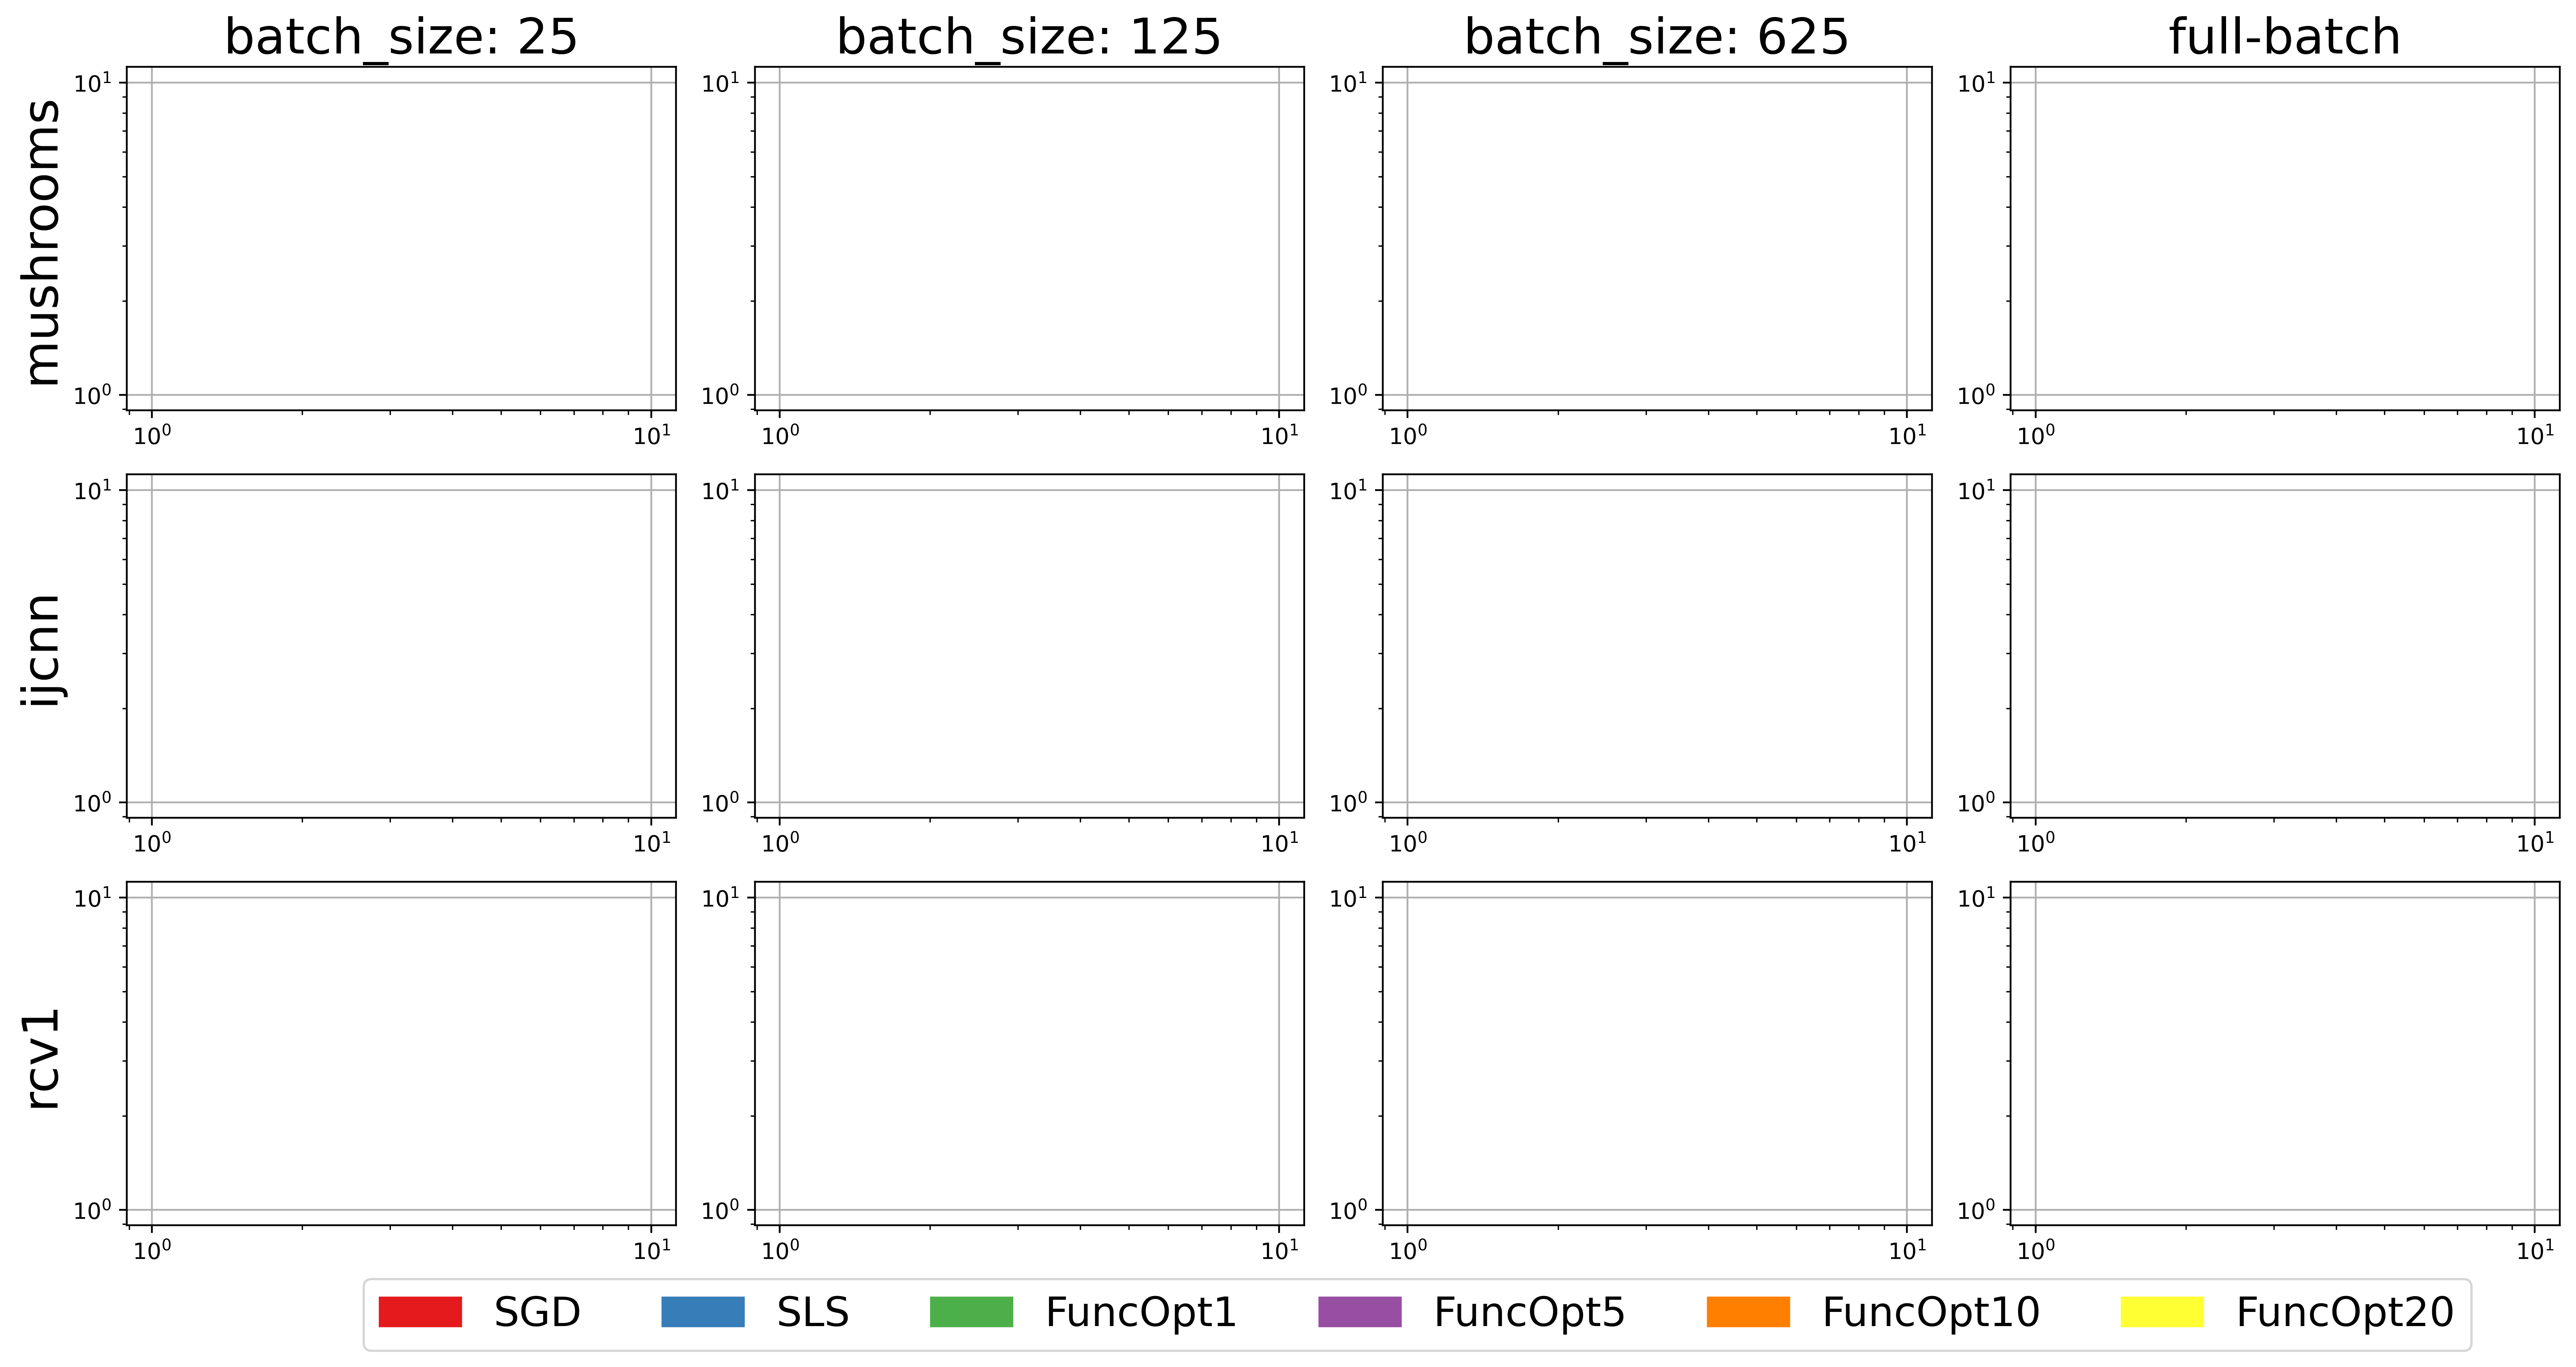

In [101]:
# generate_figure_1a('MSELoss', 'exponential', wandb_records) 